In [1]:
import sys
sys.path = ['',
 '/cm/shared/sw/pkg-old/devel/python2/2.7.13/bin',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python27.zip',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/plat-linux2',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/lib-tk',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/lib-old',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/lib-dynload',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/site-packages',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/site-packages/IPython/extensions',
 '/mnt/home/llevasseur/.ipython']

import warnings; warnings.simplefilter('ignore')
import tensorflow as tf
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.io
#import h5py
from skimage.transform import resize

# import matplotlib.pyplot as plt
%matplotlib inline  
from IPython import display
import pylab as pl

In [2]:
tf.enable_eager_execution()

In [3]:
execfile("AE_RIM_definitions.py")

In [4]:
from PIL import Image

In [5]:
def data_batch(batch_size):
    SRC = np.zeros((batch_size,212,212))
    #while math.isnan(np.max(SRC))
    inds = np.random.randint(1, high = 9999 , size= batch_size)
    for i in range(batch_size):
        SRC[i,:,:] = np.array(Image.open('/mnt/home/yhezaveh/DATA/Sherlock/ARCS_2/train_' +  "%07d" % (inds[i]) +'_source.png'),dtype='float32')/65535.0
    SRC = np.moveaxis( SRC , 0 , 2)
    SRC = resize(SRC, (npix_side,npix_side), order=1, preserve_range=True)
    SRC = np.moveaxis( SRC , 2 , 0)        
    for i in range(batch_size):
        SRC[i,:,:] = SRC[i,:,:] / np.max(SRC[i,:,:])
    return SRC

In [6]:
batch_size = 50
npix_side = 512

In [7]:
VAE_obj = VAE(n_latent = 64 , npix_side = npix_side)

In [8]:
load_checkpoint_path = "checkpoints/model_VAE_512"
save_checkpoint_path = "checkpoints/model_VAE_512_src"
RESTORE = True
if (RESTORE==True):
    VAE_obj.load_weights(load_checkpoint_path)

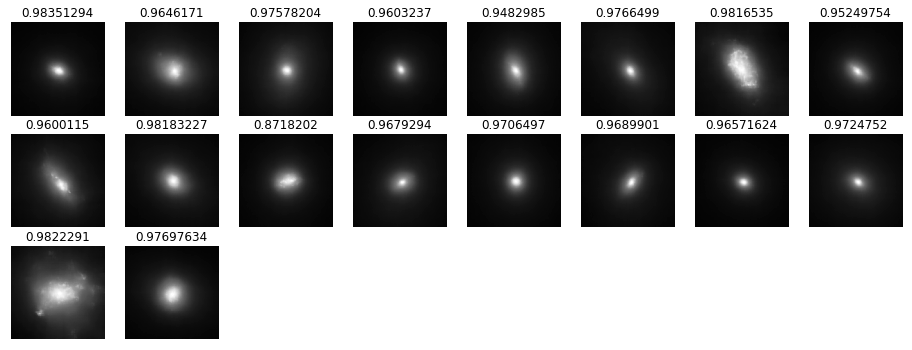

In [9]:
with tf.device('/gpu:0'):
    ims = VAE_obj.draw_image(18)
    fig = plot(ims)
    #plt.savefig('out_conv/{}.png'.format(str(im_i).zfill(3)), bbox_inches='tight')
    #plt.close(fig)



In [13]:
optimizer = tf.train.AdamOptimizer(1e-4)

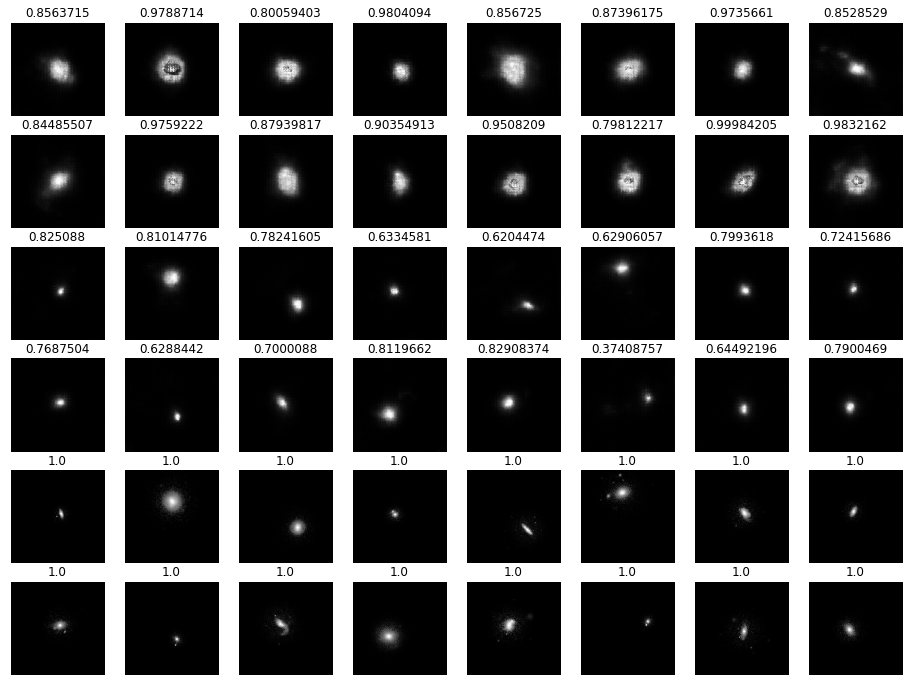

1401
1402
1403
1404
1405
1406
1407
1408
1409
1410
1411
1412
1413
1414
1415
1416
1417
1418
1419
1420
1421
1422
1423
1424
1425
1426
1427
1428
1429
1430
1431
1432


In [ ]:
im_i = 0
with tf.device('/gpu:0'):
    for train_iter in range(10000000):
        print train_iter
        batch_src = data_batch(batch_size)
        batch_src = tf.cast( batch_src , datatype)

        with tf.GradientTape() as tape:
            tape.watch(VAE_obj.variables)
            cost_value , decoded_im = VAE_obj.cost(batch_src)
        weight_grads = tape.gradient(cost_value, [VAE_obj.variables] )

        clipped_grads = [tf.clip_by_value(grads_i,-10,10) for grads_i in weight_grads[0]]
        optimizer.apply_gradients(zip(clipped_grads, VAE_obj.variables), global_step=tf.train.get_or_create_global_step())

        if (((train_iter+1)%50)==1):
            im_i = im_i + 1
            #print( "saving weights." )
            #VAE_obj.save_weights(save_checkpoint_path)
            #print( "done." )
            ims = VAE_obj.draw_image(16)
            ims = [np.reshape(ims[i].numpy(), [npix_side, npix_side]) for i in range(16)] + [np.reshape(decoded_im[i,:,:], [npix_side, npix_side]) for i in range(16)] + [np.reshape(batch_src[i,:,:], [npix_side, npix_side]) for i in range(16)]
            pl.clf()
            fig = plot(ims)
            display.clear_output(wait=True)
            display.display(pl.gcf())

